# **Logistic Regression**

### **1. Get data**

In [1]:
from pyspark.sql import SparkSession

# Create a Spark session
spark = SparkSession.builder \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "15g") \
    .appName("Logistic Regression Model") \
    .getOrCreate()


24/06/04 14:57:51 WARN Utils: Your hostname, MacBook-Pro-2.local resolves to a loopback address: 127.0.0.1; using 10.0.0.228 instead (on interface en0)
24/06/04 14:57:51 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/04 14:57:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# Read training data
train_df = spark.read.csv("data/train.csv", header=True, inferSchema=True)
train_df = train_df.drop("_c0")

# Read test data
test_df = spark.read.csv("data/test.csv", header=True, inferSchema=True)
test_df = test_df.drop("_c0")

train_df.show(5)

24/06/04 14:58:06 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


+----------+---------+--------+-------------+--------------------+-------------------+-------+------------------+---------------------+
|product_id|reordered|aisle_id|department_id|fav_aisle_aggregated|fav_dept_aggregated|cluster| avg_cart_position|avg_purchase_interval|
+----------+---------+--------+-------------+--------------------+-------------------+-------+------------------+---------------------+
|     33120|        0|      86|           16|                  24|                  4|      0|              11.0|                 11.2|
|     21903|        0|     123|            4|                  24|                  4|      0| 4.176470588235294|    8.941176470588236|
|     24852|        1|      24|            4|                  24|                  4|      0|4.6923076923076925|                10.92|
|     47766|        1|      24|            4|                  24|                  4|      0|               6.0|                  7.0|
|     35951|        0|      91|           16|   

In [3]:
print("Training Dataset Count: " + str(train_df.count()))
print("Test Dataset Count: " + str(test_df.count()))

Training Dataset Count: 24142994
Test Dataset Count: 975782


In [4]:
label_counts = train_df.groupBy("reordered").count()
label_counts.show()

+---------+--------+
|reordered|   count|
+---------+--------+
|        1|14492645|
|        0| 9650349|
+---------+--------+



In [5]:
# total_samples = 19000000
# desired_samples_per_label = total_samples // 2  # aiming for 9,500,000 samples for each label

# count_label_0 = 9650349
# count_label_1 = 14492645

# fraction_label_0 = desired_samples_per_label / count_label_0
# fraction_label_1 = desired_samples_per_label / count_label_1

# fractions = {0: fraction_label_0, 1: fraction_label_1}

# # Apply stratified sampling
# train_sampled = train_df.sampleBy("reordered", fractions, seed=42)

In [6]:
# Check the count of each label in the 'reordered' column
# label_counts = train_df.groupBy("reordered").count()
# print("Counts in 'reordered' column of train_limit:")
# label_counts.show()

#### 1.1. Split train_df into train and validation data

In [7]:
train_data, validation_data = train_df.randomSplit([0.8, 0.2], seed=42)

print("Training Dataset Count: " + str(train_data.count()))
print("Validation Dataset Count: " + str(validation_data.count()))

Training Dataset Count: 19313049


Validation Dataset Count: 4829945


### **2. Data Preprocessing**

In [8]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline

In [9]:
numeric_features = ["avg_cart_position", "avg_purchase_interval"]
categorical_features = ["product_id", "aisle_id", "department_id", "fav_aisle_aggregated", "fav_dept_aggregated", "cluster"]

#### 2.1. Build Pipeline and Fit

In [10]:
# sample_df = train_data.sample(fraction=0.01).limit(5)
# sample_df.show()

In [11]:
'''
    Indexing categorical columns:
    - The indexer assigns a unique index to each category based on 
        the frequency of the category appearing in the dataset 
        (most frequent category gets index 0)
'''

indexers = [
    StringIndexer(inputCol=column, outputCol=column+"_index", handleInvalid="keep")
    for column in categorical_features
]
# for indexer in indexers:
#     sample_df = indexer.fit(sample_df).transform(sample_df)
#     sample_df.show()

In [12]:
'''
    Encoding categorical columns:
    - OneHotEncoder (PySpark transformer): convert each index of a categorical feature into 
        a binary vector with at most a single one-value indicating the presence of 
        a specific feature value from among the set of all feature values.
'''

encoder = OneHotEncoder(
    inputCols=[indexer.getOutputCol() for indexer in indexers],
    outputCols=[f"{column}_encoded" for column in categorical_features]
)

# sample_df = encoder.fit(sample_df).transform(sample_df)
# sample_df.show()

In [13]:
'''
    VectorAssembler: transformer that combines multiple columns of data into a single vector column
    Output: one column of all features
'''
num_assembler = VectorAssembler(inputCols=numeric_features, outputCol="num_features")

# sample_df = num_assembler.transform(sample_df)

'''
    Scaling numerical features
'''
scaler = StandardScaler(inputCol="num_features", outputCol="scaled_numeric_features")

# scaler_model = scaler.fit(sample_df)
# sample_df = scaler_model.transform(sample_df)
# sample_df.show()

In [14]:
final_assembler = VectorAssembler(
    inputCols=[f"{column}_encoded" for column in categorical_features] + ["scaled_numeric_features"],
    outputCol="features"
)

# sample_df = final_assembler.transform(sample_df)
# sample_df.show()

In [15]:
# Pipeline: include indexer stages, encoder, num_assembler, scaler, and final_assembler
pipeline = Pipeline(stages=indexers + [encoder, num_assembler, scaler, final_assembler])

In [16]:
# Fit pipeline to training data
pipeline_model = pipeline.fit(train_data)

In [17]:
# Transform both training and validation data using the fitted pipeline model
train_transformed = pipeline_model.transform(train_data)
validation_transformed = pipeline_model.transform(validation_data)

In [18]:
train_transformed.printSchema()

root
 |-- product_id: integer (nullable = true)
 |-- reordered: integer (nullable = true)
 |-- aisle_id: integer (nullable = true)
 |-- department_id: integer (nullable = true)
 |-- fav_aisle_aggregated: integer (nullable = true)
 |-- fav_dept_aggregated: integer (nullable = true)
 |-- cluster: integer (nullable = true)
 |-- avg_cart_position: double (nullable = true)
 |-- avg_purchase_interval: double (nullable = true)
 |-- product_id_index: double (nullable = false)
 |-- aisle_id_index: double (nullable = false)
 |-- department_id_index: double (nullable = false)
 |-- fav_aisle_aggregated_index: double (nullable = false)
 |-- fav_dept_aggregated_index: double (nullable = false)
 |-- cluster_index: double (nullable = false)
 |-- product_id_encoded: vector (nullable = true)
 |-- aisle_id_encoded: vector (nullable = true)
 |-- department_id_encoded: vector (nullable = true)
 |-- fav_aisle_aggregated_encoded: vector (nullable = true)
 |-- fav_dept_aggregated_encoded: vector (nullable = t

#### 2.2. Fit Logistic Regression Model

In [19]:
from pyspark.ml.classification import LogisticRegression
import numpy as np

In [20]:
lr = LogisticRegression(featuresCol='features', labelCol='reordered', maxIter=1000, tol=0.0001)

In [21]:
# spark.sparkContext._conf.getAll()  # check the config

# num_partitions = 10  # n parts

# # Repartition DataFrame
# train_data_partitioned = train_transformed.repartition(num_partitions)
# validation_data_partitioned = validation_transformed.repartition(num_partitions)

In [22]:
# Fit initial model
lr_model = lr.fit(train_transformed)

24/06/04 15:01:22 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
24/06/04 15:03:41 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
24/06/04 15:03:42 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/06/04 15:03:42 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
24/06/04 15:03:42 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
24/06/04 15:06:17 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
24/06/04 15:06:18 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
24/06/04 15:06:20 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
24/06/04 15:06:20 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
24/06/04 15:06:21 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
24/06/04 15:06:22 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
24/06/04 

In [23]:
predictions = lr_model.transform(validation_transformed)

In [24]:
print(predictions.count())
predictions.select(["reordered", "prediction"]).show(10)

4829945


24/06/04 15:07:32 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB


+---------+----------+
|reordered|prediction|
+---------+----------+
|        1|       1.0|
|        0|       0.0|
|        0|       0.0|
|        0|       1.0|
|        1|       1.0|
|        1|       1.0|
|        1|       1.0|
|        1|       1.0|
|        0|       1.0|
|        0|       1.0|
+---------+----------+
only showing top 10 rows



#### Evaluation

24/06/05 14:52:54 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
24/06/05 14:54:21 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB


AUC-ROC: 0.7383
Accuracy: 0.6942
Precision: 0.7075
Recall: 0.8364


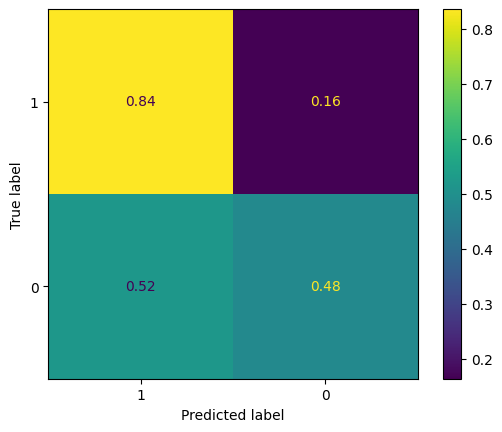

In [39]:
# Ensure all necessary imports
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Evaluate model
binary_evaluator = BinaryClassificationEvaluator(labelCol="reordered")
auc = binary_evaluator.evaluate(predictions, {binary_evaluator.metricName: "areaUnderROC"})

# Confusion matrix
class_temp = predictions.select("reordered").groupBy("reordered").count().sort('count', ascending=False).toPandas()
class_names = class_temp["reordered"].values.tolist()

y_true = predictions.select("reordered").toPandas()["reordered"].to_numpy()
y_pred = predictions.select("prediction").toPandas()["prediction"].to_numpy()

cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

# Multiclass classification evaluator for other metrics
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) != 0 else 0
recall = tp / (tp + fn) if (tp + fn) != 0 else 0

print(f"AUC-ROC: {auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Display confusion matrix in percent rate
cm = confusion_matrix(y_true, y_pred, labels=class_names, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot()
plt.show()


#### Features Importances

In [32]:
feature_importances = lr_model.coefficients
feature_names = final_assembler.getInputCols()

feature_importance_list = [(feature, importance) for feature, importance in zip(feature_names, feature_importances)]
feature_importance_list  = sorted(feature_importance_list, key=lambda x: abs(x[1]), reverse=True)
for feature, importance in feature_importance_list:
    print(f"Feature: {feature}, Importance: {importance}")

Feature: product_id_encoded, Importance: 0.9435895837895862
Feature: aisle_id_encoded, Importance: 0.7973971898745966
Feature: fav_aisle_aggregated_encoded, Importance: 0.7180967766806271
Feature: fav_dept_aggregated_encoded, Importance: 0.545627572386023
Feature: department_id_encoded, Importance: 0.48433017446109977
Feature: cluster_encoded, Importance: 0.4652230477722137
Feature: scaled_numeric_features, Importance: 0.198268540451126


In [30]:
# import lime.lime_tabular # type: ignore
# import pandas as pd

# from pyspark.ml.linalg import DenseVector
# from pyspark.sql import Row

# def predict_fn(data):
#     # Convert the numpy array to a Spark DataFrame
#     df = spark.createDataFrame([Row(features=DenseVector(row)) for row in data.tolist()])

#     # Transform the DataFrame using the trained model
#     predictions = lr_model.transform(df)
#     print("done predictions")
    
#     # Extract the probability column as a numpy array
#     probs = predictions.select('probability').collect()
#     probs = np.array(probs).reshape(len(data),2)
#     return probs

# # Initialize LIME explainer
# explainer = lime.lime_tabular.LimeTabularExplainer(
#     training_data=train_transformed.select('features').toPandas().to_numpy(),
#     feature_names=final_assembler.getInputCols(),
#     class_names=['Not Reordered', 'Reordered'],
#     mode='classification'
# )

# # Select an instance to explain
# instance = validation_transformed.select('features').collect()[0][0]
# print("instance: ", instance)

# # Explain the instance
# exp = explainer.explain_instance(
#     data_row=instance,
#     predict_fn=predict_fn
# )

# # Display the explanation
# # exp.show_in_notebook()
# print(exp.as_list())
# exp.save_to_file('lime_explanation.html')

##### Save Model

In [35]:
import os

model_save_path = "model/lr_base_model"
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

In [37]:
try:
    lr_model.write().overwrite().save(model_save_path)
    print(f"Model saved successfully at {model_save_path}")
except Exception as e:
    print(f"Error saving the model: {e}")

Model saved successfully at model/lr_base_model


In [38]:
# Load the model
# from pyspark.ml.classification import LogisticRegressionModel
# loaded_lr_model = LogisticRegressionModel.load("/path/to/save/model")


In [34]:
print(spark.sparkContext.getConf().getAll())

[('spark.sql.warehouse.dir', 'file:/Users/nhungluong/Local%20Documents/Extra%20Learning/DS&ML/Instacart/spark-warehouse'), ('spark.driver.extraJavaOptions', '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/jdk.internal.ref=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/sun.security.krb5=ALL-UNNAMED -Djdk.reflect.useDirectMetho